In [1]:
%pylab inline
import os
import jax
import jax.numpy as np
import jax_cosmo as jc
import numpyro
import numpyro.distributions as dist

Populating the interactive namespace from numpy and matplotlib


/local/home/flanusse/.local/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/local/home/flanusse/.local/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [2]:
# Let's grab the data file
from astropy.io import fits
if not os.path.isfile('2pt_NG_mcal_1110.fits'):
    !wget http://desdr-server.ncsa.illinois.edu/despublic/y1a1_files/chains/2pt_NG_mcal_1110.fits

nz_source=fits.getdata('2pt_NG_mcal_1110.fits', 6)
nz_lens=fits.getdata('2pt_NG_mcal_1110.fits', 7)

# This is the effective number of sources from the cosmic shear paper
neff_s = [1.47, 1.46, 1.50, 0.73]
nzs_s = [jc.redshift.kde_nz(nz_source['Z_MID'].astype('float32'),
                            nz_source['BIN%d'%i].astype('float32'), 
                            bw=0.01,
                            gals_per_arcmin2=neff_s[i-1])
           for i in range(1,5)]
nzs_l = [jc.redshift.kde_nz(nz_lens['Z_MID'].astype('float32'),
                            nz_lens['BIN%d'%i].astype('float32'), bw=0.01)
        for i in range(1,6)]

# Define some ell range
ell = np.logspace(1, 3)

In [3]:
# Let's define our model using numpyro
# Papier https://arxiv.org/pdf/1708.01530.pdf  and desy1.py
def model():
    #  Cosmological params
    Omega_c = numpyro.sample('Omega_c', dist.Uniform(0.1, 0.9))
    sigma8 = numpyro.sample('sigma8', dist.Uniform(0.4, 1.0))
    Omega_b = numpyro.sample('Omega_b', dist.Uniform(0.03, 0.07))
    h = numpyro.sample('h', dist.Uniform(0.55, 0.91))
    n_s = numpyro.sample('n_s', dist.Uniform(0.87, 1.07)) 
    w0 = numpyro.sample('w0', dist.Uniform(-2.0, -0.33))

    # Intrinsic Alignment
    A = numpyro.sample('A', dist.Uniform(-5., 5.))
    eta = numpyro.sample('eta', dist.Uniform(-5., 5.))

    # linear galaxy bias
    bias = [numpyro.sample('b%d'%i, dist.Uniform(0.8, 3.0)) 
         for i in range(1,6)]
        
    # parameters for systematics
    m = [numpyro.sample('m%d'%i, dist.Normal(0.012, 0.023)) 
         for i in range(1,5)]
    dz1 = numpyro.sample('dz1', dist.Normal(0.001, 0.016)) 
    dz2 = numpyro.sample('dz2', dist.Normal(-0.019, 0.013)) 
    dz3 = numpyro.sample('dz3', dist.Normal(0.009, 0.011)) 
    dz4 = numpyro.sample('dz4', dist.Normal(-0.018, 0.022)) 
    dz = [dz1, dz2, dz3, dz4]
    
    # Now that params are defined, here is the forward model
    cosmo = jc.Cosmology(Omega_c=Omega_c, sigma8=sigma8, Omega_b=Omega_b,
                          h=h, n_s=n_s, w0=w0, Omega_k=0., wa=0.)
    
    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi, zmax=2.0) 
                for nzi, dzi in zip(nzs_s, dz)]
    
    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)

    # Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in bias] 
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l, b)]

    cl, C = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, probes, 
                                                          f_sky=0.25, sparse=True)
    
    P = jc.sparse.to_dense(jc.sparse.inv(C))
    C = jc.sparse.to_dense(C)
    return cl, P, C

In [4]:
from numpyro.handlers import seed, trace, condition
# So, let's generate the data at the fiducial parameters
fiducial_model = condition(model,
    {'Omega_c':0.2545, 'sigma8':0.801, 'h':0.682, 'Omega_b':0.0485, 'w0':-1.,'n_s':0.971,
     'A':0.5,'eta':0.,
     'm1':0.0,'m2':0.0,'m3':0.0,'m4':0.0,
     'dz1':0.0,'dz2':0.0,'dz3':0.0,'dz4':0.0,
     'b1':1.2,'b2':1.4,'b3':1.6,'b4':1.8,'b5':2.0
      })

with seed(rng_seed=42):
    data, P, C = fiducial_model()

/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


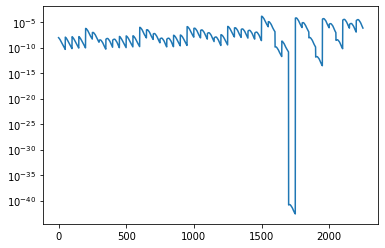

In [5]:
# This is our fake data vector
semilogy(data);

In [6]:
from numpyro.distributions.transforms import AffineTransform

def Uniform(name, min_value, max_value):
    """ Creates a Uniform distribution in target range from a base
    distribution between [-5, 5]
    """
    s = (max_value - min_value) / 10.
    return numpyro.sample(
            name,
            dist.TransformedDistribution(
                dist.Uniform(-5., 5.),
                AffineTransform(min_value + 5.*s, s),
            ),
        )

In [7]:
# Let's define our model using numpyro
# Papier https://arxiv.org/pdf/1708.01530.pdf  and desy1.py
def model():
    #  Cosmological params
    Omega_c = Uniform('Omega_c', 0.1, 0.9)
    sigma8 = Uniform('sigma8', 0.4, 1.0)
    Omega_b = Uniform('Omega_b', 0.03, 0.07)
    h = Uniform('h',0.55, 0.91)
    n_s = Uniform('n_s', 0.87, 1.07)
    w0 = Uniform('w0', -2.0, -0.33)

    # Intrinsic Alignment
    A = Uniform('A', -5., 5.)
    eta = Uniform('eta', -5., 5.)

    # linear galaxy bias
    bias = [Uniform('b%d'%i, 0.8, 3.0)
         for i in range(1,6)]
        
    # parameters for systematics
    m = [numpyro.sample('m%d'%i, dist.Normal(0.012, 0.023)) 
         for i in range(1,5)]
    dz1 = numpyro.sample('dz1', dist.Normal(0.001, 0.016)) 
    dz2 = numpyro.sample('dz2', dist.Normal(-0.019, 0.013)) 
    dz3 = numpyro.sample('dz3', dist.Normal(0.009, 0.011)) 
    dz4 = numpyro.sample('dz4', dist.Normal(-0.018, 0.022)) 
    dz = [dz1, dz2, dz3, dz4]
    
    # Now that params are defined, here is the forward model
    cosmo = jc.Cosmology(Omega_c=Omega_c, sigma8=sigma8, Omega_b=Omega_b,
                          h=h, n_s=n_s, w0=w0, Omega_k=0., wa=0.)
    
    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi, zmax=2.0) 
                for nzi, dzi in zip(nzs_s, dz)]
    
    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)

    # Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in bias] 
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l, b)]

    cl = jc.angular_cl.angular_cl(cosmo, ell, probes).flatten()
    
    return numpyro.sample('cl', dist.MultivariateNormal(cl, 
                                                        precision_matrix=P,
                                                        covariance_matrix=C))

In [8]:
# Now we condition the model on obervations
observed_model = condition(model, {'cl': data})

In [9]:
from numpyro.infer.reparam import LocScaleReparam, TransformReparam

def config(x):
    if type(x['fn']) is dist.TransformedDistribution:
        return TransformReparam()
    elif type(x['fn']) is dist.Normal and ('decentered' not in x['name']):
        return LocScaleReparam(centered=0)
    else:
        return None

observed_model_reparam = numpyro.handlers.reparam(observed_model, config=config)

In [10]:
nuts_kernel = numpyro.infer.NUTS(observed_model_reparam,
                                 step_size=1e-3, 
                                 init_strategy=numpyro.infer.init_to_median,
                                 max_tree_depth=7,
                                 dense_mass=[("Omega_c_base", "Omega_b_base", "sigma8_base", "h_base", "w0_base"), 
                                             ("n_s_base",), ("A_base",), ("eta_base",), 
                                             ("b1_base", "b2_base", "b3_base", "b4_base", "b5_base",),
                                             ("dz1_decentered",), ('dz2_decentered',), ('dz3_decentered',), ('dz4_decentered',),
                                             ("m1_decentered",), ('m2_decentered',), ('m3_decentered',), ('m4_decentered',)])

In [11]:
mcmc = numpyro.infer.MCMC(nuts_kernel, 
                          num_warmup=200, 
                          num_samples=1000,
                          num_chains=16,
                          chain_method='vectorized',
                          progress_bar=False)

In [12]:
# This takes about 4h on a TitanXp GPU
mcmc.run(jax.random.PRNGKey(42))

/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/local/home/flanusse/.local/lib/python3.8/site-pac

In [13]:
import pickle
with open('state_2.pckl', 'wb') as f:
    pickle.dump(mcmc.last_state,f )

In [14]:
mcmc.print_summary()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
          A_base      0.48      0.05      0.48      0.39      0.57  11162.98      1.00
    Omega_b_base     -0.36      1.43     -0.35     -2.60      2.11   8240.76      1.00
    Omega_c_base     -3.11      0.13     -3.11     -3.31     -2.88   7925.49      1.00
         b1_base     -3.17      0.07     -3.17     -3.28     -3.06   7557.49      1.00
         b2_base     -2.26      0.08     -2.26     -2.40     -2.12   7913.49      1.00
         b3_base     -1.35      0.10     -1.35     -1.51     -1.18   7798.90      1.00
         b4_base     -0.43      0.12     -0.43     -0.63     -0.24   7670.21      1.00
         b5_base      0.48      0.14      0.48      0.25      0.69   7550.42      1.00
  dz1_decentered     -0.31      0.61     -0.32     -1.30      0.70   6981.36      1.00
  dz2_decentered      1.05      0.51      1.06      0.19      1.89   7673.32      1.00
  dz3_decentered     -0.79      0.53     -